# Demo for applying NCD towards biological data

This demo showcases a sample NCD calculation, as well as what the output of our compression pipeline should look like. Here we use the Lempel-Ziv Markov Algorihtm (LZMA) as our compression tool.

In [1]:
import sys
sys.path.append('../scripts')
#call Python script
import pairwise_ncd
#import matrix handling tools
import numpy as np
import pandas as pd
import csv
#import kmeans clustering
from sklearn.cluster import KMeans

## Input sample sequences (2 for the purposes of this demo)

Sample sequences are "mystery" bacterial genomes of unknown taxonomy. We'll use these to test our pipeline.

In [2]:
with open ("../test_dataset/mysteryGenome_1.fasta", "r") as file:
    seq1 = file.read()
with open ("../test_dataset/mysteryGenome_2.fasta", "r") as file:
    seq2 = file.read()

## Determine the size of uncompressed sequences

In [3]:
sequences12 = pairwise_ncd.return_byte(seq1,seq2)
print("Size of Sequence 1: %s bytes" % (sys.getsizeof(sequences12[0]),))
print("Size of Sequence 2: %s bytes" % (sys.getsizeof(sequences12[1]),))
print("Size of concatenated Sequence 1 & Sequence 2: %s bytes" % (sys.getsizeof(sequences12[2]),))

Size of Sequence 1: 4507943 bytes
Size of Sequence 2: 4474285 bytes
Size of concatenated Sequence 1 & Sequence 2: 8982195 bytes


Our sequences are pretty similar in size, concatenating both of them together approximately doubles their size, which is to be expected.

## Now determine size of compressed sequences

In [4]:
#Our compression algorithm is the rate-limiting step in this pipeline.
sizes12 = pairwise_ncd.compressed_size(sequences12)
print("Sequence 1: %s bytes" % (sizes12[0],))
print("Sequence 2: %s bytes" % (sizes12[1],))
print("Concatenated Sequences 1 & 2: %s bytes" % (sizes12[2],))

Sequence 1: 1174721 bytes
Sequence 2: 1173133 bytes
Concatenated Sequences 1 & 2: 1242873 bytes


Our original sequences are compressed to 1/4 of their original size, but our concatenated sequence shrunk by a factor of 8! A good sign that our choice of compression algorithm is working well.

## Computing NCD values

In [5]:
ncd12 = pairwise_ncd.compute_distance(sizes12[0], sizes12[1], sizes12[2])
print("NCD12 = %s" % (ncd12,))

NCD12 = 0.05936728806244206


All NCD does is return a value between 0 and 1. The closer it is to 0, the more similar both inputs are to each other (conversely, closer to 1 = more distant). We'll now skip forward and provide a matrix for all pairwise combinations of our 8 mystery genomes.

## Distance Matrix of NCD values

In [6]:
distance_matrix = pd.read_csv('../test_dataset/distance_matrix_mysteryGenome1-8.csv', sep=',',header=0)
print(distance_matrix)

   mysteryGenome_1  mysteryGenome_2  mysteryGenome_3  mysteryGenome_4  \
0         0.000637         0.059367         0.056388         0.074164   
1         0.059367         0.000624         0.065503         0.086240   
2         0.056388         0.065503         0.000625         0.085386   
3         0.074164         0.086240         0.085386         0.000623   
4         0.042029         0.052851         0.050750         0.072299   
5         0.061301         0.069963         0.063825         0.081414   
6         0.076284         0.058378         0.045924         0.074232   
7         0.033826         0.061723         0.045454         0.069501   

   mysteryGenome_5  mysteryGenome_6  mysteryGenome_7  mysteryGenome_8  
0         0.042029         0.061301         0.076284         0.033826  
1         0.052851         0.069963         0.058378         0.061723  
2         0.050750         0.063825         0.045924         0.045454  
3         0.072299         0.081414         0.074232  

In theory we should have 0's across the diagonal since both sequences are exactly the same, but our matrix shows that is not the case. This is because our NCD computation isn't a perfect measure of similairty, it's an approximation. In this case, values across the diagonal are 3 orders of magnitude smaller than all the rest, which will work just fine for our needs.

Now that we have a nice distance matrix, let's perform K-means clustering!

## K-means - Clustering

K-means is a simple & popular method of clustering that requries you to pre-specify the number of clusters beforehand. Let's use k = 2 and see if we can find if one of our sequences is noticeably different from all others.

In [7]:
kmeans = KMeans(n_clusters=2).fit(distance_matrix)
y_kmeans = kmeans.predict(distance_matrix)
print(y_kmeans)



[0 0 0 1 0 0 0 0]


K-means recognizes MysteryGenome4 as our outlier. Let's get a more detailed visualization...

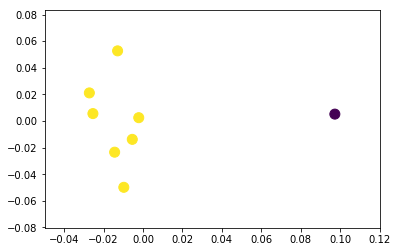

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#principal component analysis used to visualize results into a 2D grid
pca = PCA(n_components=2)
X = pca.fit_transform(distance_matrix)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=100)
plt.show();



In [9]:
print(distance_matrix)

   mysteryGenome_1  mysteryGenome_2  mysteryGenome_3  mysteryGenome_4  \
0         0.000637         0.059367         0.056388         0.074164   
1         0.059367         0.000624         0.065503         0.086240   
2         0.056388         0.065503         0.000625         0.085386   
3         0.074164         0.086240         0.085386         0.000623   
4         0.042029         0.052851         0.050750         0.072299   
5         0.061301         0.069963         0.063825         0.081414   
6         0.076284         0.058378         0.045924         0.074232   
7         0.033826         0.061723         0.045454         0.069501   

   mysteryGenome_5  mysteryGenome_6  mysteryGenome_7  mysteryGenome_8  
0         0.042029         0.061301         0.076284         0.033826  
1         0.052851         0.069963         0.058378         0.061723  
2         0.050750         0.063825         0.045924         0.045454  
3         0.072299         0.081414         0.074232  

Looks good, although labels and a better visualization are required.

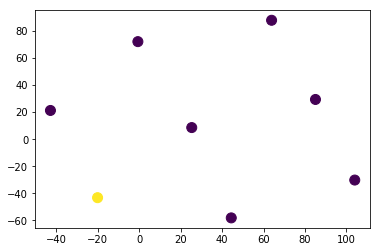

In [10]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=300)

X_2d = tsne.fit_transform(distance_matrix)

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_kmeans, s=100)
plt.show();


# Bokeh Plots

In [11]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource, gridplot
from bokeh.io import output_notebook
from bokeh.palettes import Spectral6
from bokeh.transform import linear_cmap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# output to static HTML file
#output_file("Plots.html", title="NCD Output")
# output to notebook
output_notebook()

# tool tips to display on hoover
TOOLTIPS = [
    ("Sequence", "$index"),
    ("(x,y)", "($x, $y)"),
]

# generate enough random colours to cover our clusters
colors = np.array([x for x in ('#00f', '#0f0', '#f00', '#0ff', '#f0f', '#ff0')])
colors = np.hstack([colors] * 20)

# read the distance matrix
distance_matrix = pd.read_csv('../test_dataset/distance_matrix_mysteryGenome1-8.csv', sep=',',header=0)

# cluster with k-means
kmeans = KMeans(n_clusters=2).fit(distance_matrix)
y_kmeans = kmeans.predict(distance_matrix)

#PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(distance_matrix)


# create a new plot for PCA
p1 = figure(width=400, height=400, tooltips=TOOLTIPS, title="PCA")
# add renderers
p1.circle(X_pca[:, 0], X_pca[:, 1], color=colors[y_kmeans].tolist(), size=10, alpha=0.5)


#t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=50)
X_tsne = tsne.fit_transform(distance_matrix)

# create a new plot for t-sne
p2 = figure(width=400, height=400, tooltips=TOOLTIPS, title="tSNE")
# add renderers
p2.circle(X_tsne[:, 0], X_tsne[:, 1], color=colors[y_kmeans].tolist(), size=10, alpha=0.5)


#UMAP
X_umap = umap.UMAP(n_neighbors=5,min_dist=0.3,metric='correlation').fit_transform(distance_matrix)

# create a new plot for t-sne
p3 = figure(width=400, height=400, tooltips=TOOLTIPS, title="UMAP")
# add renderers
p3.circle(X_umap[:, 0], X_umap[:, 1], color=colors[y_kmeans].tolist(), size=10, alpha=0.5)

# put all the plots in a grid layout
p = gridplot([[p1, p2],[p3, None]])

# show the results
show(p)

Loading BokehJS ...